### 0. Some libraries

In [1]:
from time import time
start = time()

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import tracemalloc
tracemalloc.start()

### 1. Data

In [3]:
bank_data = pd.read_csv('bank-additional-full.csv', sep=';')
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### 2. Feature Encoding

In [4]:
## Removing rows with unknowns in them

for col in bank_data.columns:
    bank_data = bank_data[bank_data[col] != 'unknown']

In [5]:
## Binary encoding for label and other columns

bank_data["y"] = bank_data["y"].map({'yes':1, 'no':0})

yes_no = {'yes':0, 'no':1}

bank_data["housing"] = bank_data["housing"].map(yes_no)
bank_data["loan"] = bank_data["loan"].map(yes_no)
bank_data["default"] = bank_data["default"].map(yes_no)


## Ordinal encoding for education, marital and contact

bank_data["education"] = bank_data["education"].map({'basic.4y':1, 'high.school':4, 'basic.6y':2, 'basic.9y':3,
                                         'professional.course':6, 'university.degree':5,
                                         'illiterate':0})

bank_data["marital"] = bank_data["marital"].map({'married':2, 'divorced':0, 'single':1})
bank_data["contact"] = bank_data["contact"].map({'telephone':1, 'cellular':2})

<AxesSubplot:xlabel='pdays', ylabel='Probability'>

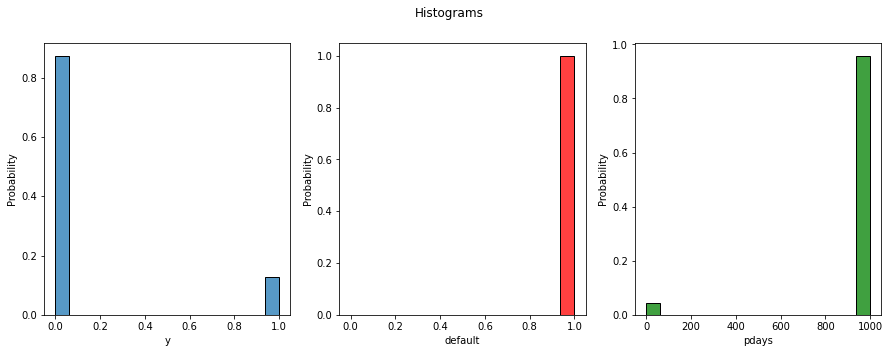

In [6]:
## looking at label distribution for target(y), default and pdays

fig, axes = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Histograms')
sns.histplot(ax=axes[0], data=bank_data, x='y', stat='probability')
sns.histplot(ax=axes[1], data=bank_data, x='default', stat='probability', color='red')
sns.histplot(ax=axes[2], data=bank_data, x='pdays', stat='probability', color='green')

In [7]:
## Looking for dependency in "technical" features

corr = bank_data[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']].corr(numeric_only=True)
corr.style.format(precision=2)

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
emp.var.rate,1.00,0.77,0.16,0.97,0.90,-0.31
cons.price.idx,0.77,1.00,0.03,0.67,0.49,-0.13
cons.conf.idx,0.16,0.03,1.00,0.24,0.08,0.06
euribor3m,0.97,0.67,0.24,1.00,0.94,-0.32
nr.employed,0.90,0.49,0.08,0.94,1.00,-0.36
y,-0.31,-0.13,0.06,-0.32,-0.36,1.00


In [8]:
## Dropping "irrelevant" and "problematic" (duration) features

X = bank_data.drop(['job', 'month', 'day_of_week', 'poutcome',
                    'default', 'pdays', 'duration', 'y'], axis = 'columns')

X_cat = X.copy()

## Category encoding based on Sturge's law 
## Grouping data into bins if variety > 16

for col in ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']:
    uniq = len(X_cat[col].unique())

    sturges = 1 + round(np.log2(len(X)))

    if uniq < sturges:
        X_cat[col] = pd.cut(X[col], bins=uniq, labels=[j for j in range(uniq)])
    else:
        X_cat[col] = pd.cut(X[col], bins=sturges, labels=[j for j in range(sturges)])

y = bank_data['y']

### 3. Decision Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [10]:
## Stratified train-test split since skewed data

X_train, X_test, y_train, y_test = train_test_split(X_cat, y, stratify=y, random_state=88)

In [11]:
## defining grid for grid search
## modified from original to run in normal time

param_grid = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [j for j in range(10,101,10)],
    'min_samples_split': [j for j in range(2,15)]
}

In [12]:
## Using 'average_precision_score' as scoring since data is skewed

grid = GridSearchCV(DecisionTreeClassifier(class_weight="balanced"), 
                    param_grid, verbose=1, n_jobs=-1, 
                    refit=True, scoring='average_precision',
                    cv = 10)

In [13]:
grid.fit(X_train, y_train)

Fitting 10 folds for each of 260 candidates, totalling 2600 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14]},
             scoring='average_precision', verbose=1)

In [14]:
print('Best avg precision:{:.3f}'.format(grid.best_score_))
print('Best parameters:', grid.best_params_)

print('Test avg precision: {:.3f}'.format(grid.score(X_test, y_test)))

Best avg precision:0.380
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 14}
Test avg precision: 0.378


In [15]:
## Building final tree based on grid search

finaltree = DecisionTreeClassifier(class_weight='balanced',
                                   criterion='entropy', max_depth=10,  min_samples_split=14)
finaltree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, min_samples_split=14)

### 4a. Categorical Naive Bayes Classifier

In [16]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB

In [17]:
## Fitting categorical Naive Bayes classifier for category encoded data

cat = CategoricalNB(min_categories=10)
cat.fit(X_train, y_train)

CategoricalNB(min_categories=10)

In [18]:
cat_test = y_test
catpred = cat.predict(X_test)

### 4b. Mixture Naive Bayes Classifier

In [19]:
## Splitting not only binary encoded data
## 'X' here doesn't category encode the "technical" featuers

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, stratify=y, random_state=88)

In [20]:
category = ['marital', 'education', 'housing', 'loan', 'contact', 'campaign', 'previous']
continuous = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [21]:
## Fit Gaussian NB for continuous features

gnb = GaussianNB()
gnb.fit(X_train2[continuous], y_train2)

## Fit Bernoulli NB for categorical features

cat = BernoulliNB()
cat.fit(X_train2[category], y_train2)

BernoulliNB()

In [22]:
## Find optimal way to combine the probabilities obtained

def my_model(cont, cate, p):
    
    combined = p*cont + (1-p)*cate

    output = []

    for tup in combined:
        if tup[0] > tup[1]:
            output.append(0)
        else:
            output.append(1)

    return output

In [23]:
continuous_prob = gnb.predict_proba(X_test2[continuous])
category_prob = cat.predict_proba(X_test2[category])

In [24]:
from sklearn.metrics import classification_report, average_precision_score, accuracy_score

In [25]:
max_accuracy = -1
optim_p = -1
for p in range(1, 100, 1):
    p = p/100
    p_accuracy = average_precision_score(y_test, my_model(continuous_prob, category_prob, p))

    if p_accuracy > max_accuracy:
        max_accuracy = p_accuracy
        optim_p = p

In [26]:
print('Optimum p: {:.3f} \nMax accuracy: {:.3f}'.format(optim_p, max_accuracy))

Optimum p: 0.740 
Max accuracy: 0.295


### 5. Results

In [27]:
## Average Precision for the three classifiers built

print('Decision Tree Classifier: {:.3f}'.format(average_precision_score(y_test, finaltree.predict(X_test))))

print('Categorical NB Classifier: {:.3f}'.format(average_precision_score(y_test, catpred)))

print('Mixture NB Classifier: {:.3f}'.format(average_precision_score(y_test2, my_model(continuous_prob, category_prob, optim_p))))


Decision Tree Classifier: 0.268
Categorical NB Classifier: 0.291
Mixture NB Classifier: 0.295


In [28]:
## Full report for the best clsassifier

print('Mixture NB Model')
print(classification_report(y_test2, my_model(continuous_prob, category_prob, optim_p)))

Mixture NB Model
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      6657
           1       0.43      0.55      0.48       965

    accuracy                           0.85      7622
   macro avg       0.68      0.72      0.70      7622
weighted avg       0.87      0.85      0.86      7622



### 6. Space and Time Complexity

In [29]:
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print("Memory used")
print("Current [MB]", round(current/(1024*1024), 2))
print("Peak [MB]", round(peak//(1024*1024), 2))

Memory used
Current [MB] 44.42
Peak [MB] 48


In [31]:
print("Time elapsed [s] ", round(time() - start, 2))

Time elapsed [s]  51.25
